# Let's Get Linear: Singular Value Decomposition

Dimension reduction finds the most important variables in the data -- or at least removes the least important ones. Firstly, it helps stream line the data analysis. It also avoids the curse of dimensionality, which is that in high dimensions the volume of the space becomes so high that all of the data seems different from each other in different ways, which makes pattern finding in the data very challenging. 

Singular Value Decomposition is a pure linear algebra method to factor data and help reduce the dimensions of a data matrix. Let's explore the math!

Let's first get our imports in.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import linalg as LA

import anime_svd as aSVD

And import our guiding example for SVD, which is a matrix of user's ratings for different animes. The rows of the matrix are the users and the columns are animes.

In [2]:
# Import data
ratings = pd.read_csv("rating.csv")
animes = pd.read_csv("anime.csv")

np_matrix, anime_ids = aSVD.make_matrix(ratings, animes) 

np_matrix.shape

(1145, 5287)

## A less mathy construction

Let's think of a matrix M that is $m \times n$ as mapping something in m space to something in n space. Through SVD, we can decompose/factor the relationships M into $U \Sigma V^{T}$. 
- $U$ is an $m \times m$ matrix that maps the m space onto a concept space.
- $\Sigma$ is a diagonal matrix of size $m \times n$ that describes the strength of concept.
- $V^{T}$ is a $n \times n$ matrix that maps concepts onto n space. 

If we think about this for the anime matrix:
- $M$ maps users to animes
- $U$ might map users to a type, which we might conceptualize as genres or some other similarity between animes.
- $\Sigma$ might map the presence or strength of different genres in the dataset.
- $V^{T}$ might map types to anime.

Let's use these ideas to make sense of the matrices as we talk through the more complicated concepts.

## The nitty-gritty

Let's go through a singular value decomposition implementation to learn more about it, as well as the linear algebra behind it. 

### How to do SVD

SVD involves the matrices $MM^{T}$ and $M^{T}M$. The relationship between $M^{T}$ and $M$ is interesting; they have the same determinant, so they have the same characteristic polynomial and therefore, the same eigenvalues! 

Something special about $MM^{T}$ and $M^{T}M$, however, is that they are always symmetric and therefore have all positive eigenvalues, and they're also square. Because of their squareness, we can do something called a eigendecomposition, where $A = Q\Lambda Q^{T}$. Eigendecomposition basically means representing a matrix using it's eigenvalues on a diagonal (for our cases, let's say $\Lambda = \Sigma^{2}$) and eigenvectors (let's call those $Q = U$ and $Q = V$ respectively for $MM^{T}$ and $M^{T}M$). Since $MM^{T}$ and $M^{T}M$ are transposes of each other, they also have the same eigenvalues. 

(through eigendecompositions) $M^{T}M = U \Sigma^{2} U^{T}$ and $MM^{T} = V \Sigma^{2} V^{T}$


- $U$ is composed of the eigenvectors of $M^{T}M$.
- $\Sigma$ is a descending diagonal matrix of the square root of the eigenvalues of either $M^{T}M$ or $MM^{T}$.
- $V$ is composed of the eigenvectors of $MM^{T}$

When we solve for M, we get $M = U \Sigma V^{T}$, which is our singular value decomposition! The word singular value refers to the square root of the eigenvalues of $MM^{T}$ and $M^{T}M$ contained in $\Sigma$. Since we know those eigenvalues are always positive, we run into no issues. 

Something that's cool is that while the eigenvector decomposition can only be done for square matrices, svd can be done for any size matrix.

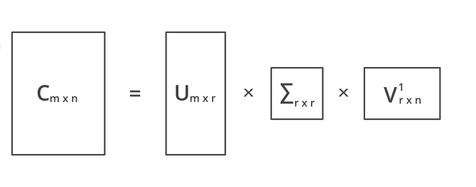

### Eigen understand SVD!

When we understand $U$, $V$, and $\Sigma$ as eigenvectors and eigenvalues (square rooted), their relationship with our intial understanding of these matrices make a little more sense. 

- Eigenvectors, as vectors, point in a direction, so they tell us about the direction of the data.
- Eigenvalues, as scalars, describe the intensity or importance of the corresponding eigenvectors. 

Let's conduct svd on our anime rating data to peek inside. 

In [3]:
U,S,Vt = np.linalg.svd(np_matrix,full_matrices=False)
print("M shape: ", np_matrix.shape) #original matrix, num users to num animes
print("number animes ", len(anime_ids))
print("U shape: ", U.shape) #Eigenvectors
print("S: ", S.shape) #singular values
print("Vt shape: ", Vt.shape) #eigenvectors again!

M shape:  (1145, 5287)
number animes  5287
U shape:  (1145, 1145)
S:  (1145,)
Vt shape:  (1145, 5287)


Adding the linear algebra into our definition of these matrices, 

- $U$ is telling us the direction of the user into the concept space using eigenvectors, i.e what concepts a user likes. 
- $\Sigma$ is telling us how the concept is present in the data set using eigenvalues square-rooted. 
- $V^{T}$, as a transpose, is telling us how the concept space maps into animes using eigenvectors, i.e. which concepts correspond to which animes. 

I'm being pretty vague about this idea of a "concept space" because the eigenvectors we're talking about aren't the eigenvectors of M itself, but $MM^{T}$ and $M^{T}M$. That means conceptually the eigenvectors are pointing into the space that $MM^{T}$ and $M^{T}M$ describe, not really into a known space. In my opinion it's actually better to leave the idea of "concept space" vague, because then you can conceptualize it as anything! Whew, that's a lot of concepts...

For some movies, let's check out this SVD!

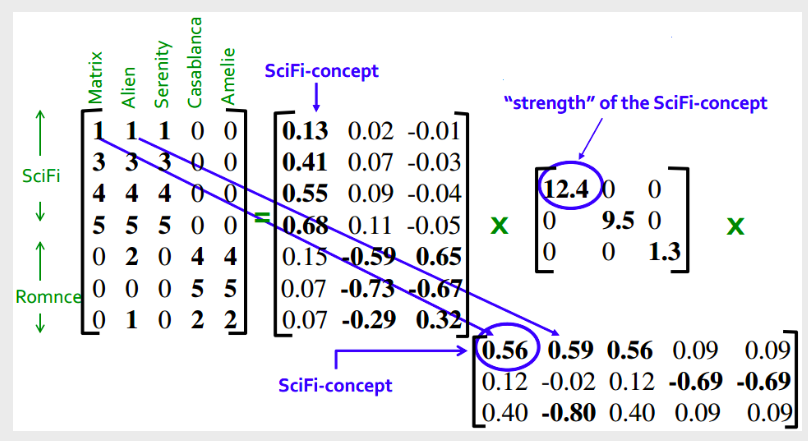

Our M matrix is a matrix that maps users to ratings of movies. From our human eye, we can identify the pattern of two genres. M is equal to a matrix multiplication of matrices we know: $U$, $\Sigma$, and $V$. In bold we see the significant numbers that characterize a user concept preferences in U. In $V^{T}$ we see how the concepts characterize different animes. 

Notice that $U$, $V$, and $\Sigma$ aren't exactly $m \times n$, $n \times n$, and $n \times n$, but rather $m \times k$, $k \times k$, and $k \times n$. Since we might only want to characterize the data by the strongest concepts (the highest eigenvalues squarerooted), we might reduce all of the matrices dimensions to include only the most important eigenvectors.

Let's check out the implementation for finding the anime recommendations contained in `anime_svd.py`

In [17]:
'''
gets recommendations for a user user_num from file names
'''
def getRecs(user_num, ratings_file, anime_file):
    #get all data
    ratings = pd.read_csv(ratings_file)
    animes = pd.read_csv(anime_file)

    #make matrix
    np_matrix, anime_ids = aSVD.make_matrix(ratings, animes) #in the np array, users ind = user -1, anime_id = anime_ids[anime_indice]

    #conduct SVD
    U,S,Vt = np.linalg.svd(np_matrix,full_matrices=False)

    #find which types that user likes
    user_preferences = np.argsort(U[user_num - 1, :])[-3:] #get the max 3 types

    reccomendations = []
    #find which animes they like that fit in that type
    for pref_ind in user_preferences:
        #sort by the best in the category
        sorted_recs = np.argsort(-Vt[pref_ind, :])
    
        #check which animes they haven't seen yet
        for sorted_rec in sorted_recs:
            if np_matrix[user_num - 1, sorted_rec] == -1:
                top_anime_id = anime_ids[sorted_rec]
                anime_ind = animes.index[animes["anime_id"] == top_anime_id].tolist()[0]
                reccomendations.append(animes[["name"]].loc[anime_ind])
                break

    #return three of these movies
    return reccomendations

When the SVD matrices are referenced, we can see how it corresponds to our guiding intuition. 

When we first reference U, we want to find the components of the eigenvectors that correspond to our user that are high, so we know which concepts they like. We don't really refer to matrix S, because we don't really care about how strong the concepts are in the overall data set. When we refer to Vt, we have our important concepts in mind, and we use that to traverse Vt for the anime's that the user hasn't seen yet. 

If we want to get recommendations for the 640th user: 

In [20]:
print(getRecs(640, "rating.csv", "anime.csv"))

[name    Yosuga no Sora: In Solitude, Where We Are Leas...
Name: 4480, dtype: object, name    Charlotte
Name: 659, dtype: object, name    InuYasha
Name: 690, dtype: object]


Feel free to compare and contrast other users. 

## Conclusion 

Singular value decomposition expands on the eigendecomposition to create a matrix factorization that can be used in dimension reduction and data analysis. It leverages the geometric properties of eigenvectors and eigenvalues to draw meaning in a real world context.

## Sources
- https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
- https://gregorygundersen.com/blog/2018/12/10/svd/#:~:text=The%20singular%20value%20decomposition%20or,that%20build%20on%20the%20SVD.
- https://francescopochetti.com/bridging-recommender-systems-dimensionality-reduction/
- https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm
- https://medium.com/@dareyadewumi650/understanding-the-role-of-eigenvectors-and-eigenvalues-in-pca-dimensionality-reduction-10186dad0c5c#:~:text=Eigenvectors%20represent%20directions.,Eigenvalues%20represent%20magnitude%2C%20or%20importance.
